In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import scipy.signal as sig
import scipy.stats as st

# 3.1 - Fourier Transforms and Spectral Analysis

## Fourier Transforms 
- Using $j=\sqrt{-1}$, $\exp\left(-j2\pi s t \right)=\cos\left(2\pi s t \right)-j\sin\left(2\pi s t \right)$. So we can express any oscillating mode with a complex exponential. 
- for a given time series the fourier transform is defined as: $$X\left(s\right)= \mathcal{F}(x)=\int^\infty_{-\infty} x\left(t\right) \exp\left(-j2\pi s t \right)dt$$
- The Fourier transform is associated with oscillating signals. s is called the sampling frequency (more on this later), X(s) is the "spectral representation of" x. It represents how much energy is associated with oscillations with sampling frequency s in the time series x.
    - note that X can be complex even if x is real. This will come up a lot. Also, the python fft code will generate complex values, so its good to know that they are coming.
    - one way to think about this is that if you only had the real part you would only get a cosine term, which would be a phase locked wave (because you only have 1 piece of information, the amplitude). With the real and imaginary part you can express a wave with an amplitude and phase, which is necessary to decompose our data into different waves which might be in different phases. 
- the inverse fourier transfrom is defined as $$x\left(t\right)=\mathcal{F}^{-1}(X)=\int^\infty_{-\infty} X\left(s\right) \exp\left(j2\pi s t \right)ds$$
    - note that some books use $\omega=2\pi s$ as a variable, in which case there needs to be an extra factor of $(2\pi)^{-1}$ in the inverse fourier transform
- $x(t)$ and $X(s)$ are called a "Fourier transform pair". Later we will take a look at a bunch of Fourier transform pairs.
### Discrete Fourier Transforms 
- In practice, we can't do continuous integrals on computers, so we need to discretize these expressions. Doing this is called a discrete Fourier transform or the DFT.
- Imagine that our data $x_k$ is discretely sampled at a set of points $t_k$, and that there are N data points.
- The discrete version of the transform is $$X_s = \sum_{k=0}^{N-1} \exp\left(-2\pi j s k \right) x_k$$
- The sampling frequencies used by this transform are 0/N, 1/N, 2/N, ..., k/N, ... N-1/N. However, it turns out that only some of these are useful. More on this in the next subsection.
- The discrete version of the inverse transform is $$ x_k = \frac{1}{N} \sum_{s}  \exp\left(2\pi j s k \right) X_s $$
- Doing these calculations is pretty annoying, fortunately they are implemented in most standard libraries, details about scipy.FFT are below. 
### Aliasing and the Nyquist Frequency
- Something odd happens with the complex exponentials we've been looking, consider trying to look at a sampling frequency $s=(N-n)/N$: $$ \exp\left(-2\pi j \frac{N-n}{N}k\right)=\exp\left(-2\pi j k\right) \exp\left(-2\pi j\frac{-n}{N}k\right)$$ but since $k$ is an integer, the first factor is just one. This means that at the locations where our time series is sampled, sampling at a rate of $s=(N-n)/N$ is going to look the same as sampling at a rate of $s=-n/N$!
    - the negative sampling rate here means that we just take the complex conjugate of our answer, so the real part is the same, but the imaginary part is multiplied by -1. 
    - If you're having a hard time visualizing this there is an example in the next cell.
- What this means is that if we use the full range of sampling frequencies is the same as calculating the fourier transform over both positive and negative parts sampling frequencies. 
- The largest sampling frequency that we resolve is (N/2)/N=1/2, because (N-N/2)/N=(N/2)/N. This frequency has a special name, the Nyquist frequency. 
- When we calculate the DFT of real data, we have two choices:
    1. ignore all frequencies below the Nyquist frequency and multiply our original data by 2, to show that we are basically double counting all the frequencies that we looked at (this is what the Random Data book does). 
    2. Convert the frequencies higher than the Nyquist frequency into corresponding negative sampling rates (this is what the scipy.fft.fft does).

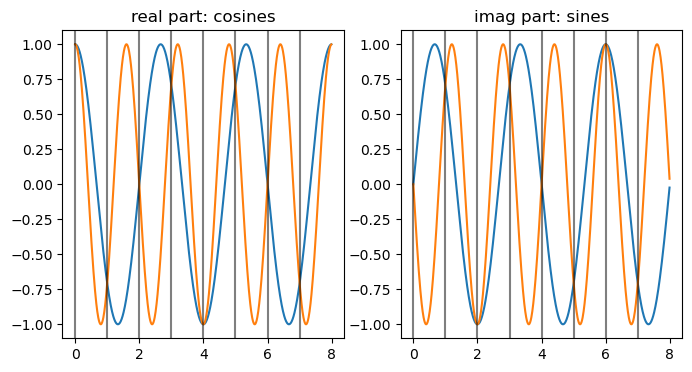

In [51]:
# example showing the aliasing for N=8 and n=3
# note that two of the cosines lie on top of each other
t=np.arange(0,8,0.01)
tint=np.arange(0,8,1)

fig,axs=plt.subplots(1,2,figsize=(8,4))

c0=np.cos(2*np.pi*t*3/8)
c1=np.cos(2*np.pi*t*5/8)
#c2=np.cos(-2*np.pi*t*2/8)

s0=np.sin(2*np.pi*t*3/8)
s1=-np.sin(2*np.pi*t*5/8)
#s2=-np.sin(-2*np.pi*t*2/8)

cl=[c0,c1]
sl=[s0,s1]
ll=[cl,sl]
tl=['real part: cosines','imag part: sines']

for i,l in enumerate(ll):
    for j,x in enumerate(l):
        axs[i].plot(t,x)
    for tsamp in tint:
        axs[i].axvline(tsamp,color='k',alpha=0.5)
    axs[i].set_title(tl[i])


### some python functions
- In the late 60s Cooley and Tukey came up with an incredibly good algorithm called the "Fast Fourier Transform", which, as the name suggests, is really fast. The details aren't really important, the gist is that they figured out that you could do the integrals in the DFT very quickly by factoring them into sequences based on prime numbers, and then recombining these sequences as needed to get the final answer. If you have N samples this reduces the operations needed from something like $\mathcal{O}(N^2)$ to $\mathcal{O}(N\log N)$, so if you have $\mathcal{O}(10^6)$ samples a normal DFT would be $\mathcal{O}(10^{12})$ calculations, but an FFT would be $\mathcal{O}(6\times 10^6)$ operations. This was such an improvement it inspired an entire revolution in scientific computing when it happened, and it underlies many digital algorithms being used today.
  
- In general programming an FFT is quite annoying. Fortunately basically every mathematical library has it implemented already. 
  
- scipy.fft is the implementation in python that I use. Under the hood its actually an interface with some super old Fortran code. 
    - scipy.fft.fft is the actual dft function
    - scipy.fft.ifft is the actual inverse dft function
  
- scipy.fft.fftfreq is an incredibly useful function, it calculates the sampling frequencies that correspond to the entries in scipy.fft.fft. An example showing this is included below.
  
- Normally scipy.fft.fft outputs frequency data that starts at 0, goes to the nyquist frequency then switches to the negative frequencies. This is ok sometimes, but it can be very annoying other times. 
  - scipy.fft.fftshift reorders the data so that frequency 0 is in the center. 

t: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
s: [ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22
  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44  0.46
  0.48 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02]


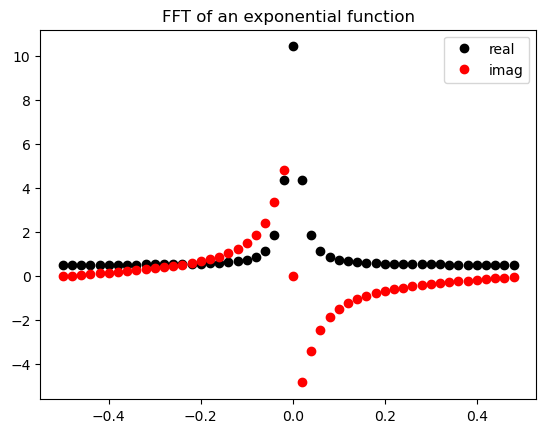

In [3]:
t=np.arange(0,50,1)
x=np.exp(-0.1*t)
X=fft.fft(x)
N=len(t)
# this gets us the fft frequencies. To get the units right we need to supply d, the sample spacing
# here though I picked d=1 on purpose to make it a little easier to understand.
s=np.fft.fftfreq(N,d=1)
print('t:',t)
print('s:',s)
plt.plot(s,np.real(X),'ko',label='real')
plt.plot(s,np.imag(X),'ro',label='imag')
plt.title('FFT of an exponential function')
plt.legend()
plt.show()


## Power Spectral Density 

- Because Fourier transforms measure the size of oscillations, it makes sense that we can use them to measure the size of oscillations. To do this, we define something called the power spectral density: $$ P_{xx}(s)=|X(s)|^2 $$ 
    - $|X(s)|^2 = X(s)X(s)^*$, where $X(s)^*$ is the complex conjugate, i.e. $\mathrm{Real}(X(s))^*=\mathrm{Real}(X(s))$ and $\mathrm{Imag}(X(s))^*=-\mathrm{Imag}(X(s))$.
    - plots of $P_{xx}$ and $s$ are called power spectra.
- An important theorem called the Wiener-Kinchin theorem states that the power spectra and the autocovariance are a Fourier transform pair, e.g.: $$ \begin{align*} P_{xx}=\mathcal{F}(C_{xx}) \\ C_{xx}=\mathcal{F}^{-1}(P_{xx}) \end{align*} $$
- This gives us two ways to calculate the power spectral density, either directly, or indirectly by calculating the autocovariance.

## Some mathematical properties of Fourier Transforms that come in handy in interpreting power spectral density  

1. **Parseval's Theorem** (the total variance of the autocovariance the power spectral density is the same): $$ \int^\infty_{-\infty} |x(t)|^2 dt  = \int^\infty_{-\infty} |X(s)|^2 ds $$
    - this is what is meant by statements like $\int^{s_0}_{s_1} |X(s)|^2 ds$ is the fraction of the variance of $x$ in the frequency band $s \in (s_0,s_1)$. The power spectral density is basically partioning the total variance into different frequency bands 
2. **The Uncertainty Relation** (The resolution of a function limits the resolution of its Fourier transform pair):
    - define the "time width" $$T_w=\left(\int^\infty_{-\infty} t^2 |x(t)|^2 dt\right)\left(\int^\infty_{-\infty} |x(t)|^2 dt\right)^{-1}$$
    - define the "frequency width" $$S_w=\left(\int^\infty_{-\infty} s^2 |X(s)|^2 ds\right)\left(\int^\infty_{-\infty} |X(s)|^2 ds\right)^{-1}$$
    - The uncertainty relation states that $$T_wS_w\geq (4\pi)^{-2}$$
    - in other words **if we have a function that is very localized in time, its Fourier transform pair must be very spread out in** frequency, and vice-versa. 
    - as an aside, you might notice that this looks a lot like the Heisenberg uncertainty relation in quantum mechanics. That's because position and momentum are a Fourier transform pair, and outside of some differences in units its exactly the same thing.
3. **The Convolution Theorem** (Convolutions in time are multiplications in Fourier space): $$ \mathcal{\mathcal{F}(x*y) = \mathcal{F}(x)\mathcal{F}(y)} $$
    - the convolution theorem is incredibly powerful in many practical situations, because doing convolutions can be quite slow compared to using an FFT, so often we can compute convolutions by: $$ x*y = \mathcal{F}^{-1}\left(\mathcal{F}(x)\mathcal{F}(y)\right) $$
    - Applied to the power spectral density this is essentially a restatement of the Weiner-Kinchin Theorem 

## Numerically calculating the Power Spectral Density 
- the results from scipy.fft will not be normalized, since the function doesn't know anything about the units of our data.
- It would be a good idea if our spectra matched Parseval's theorem, which provides the constraint that we need to normalize things.
- Comparing the expression for the discrete and continuous Fourier transforms you can find that the discrete one is missing a factor of $n^{-1}dt/2$, where $n$ is the number of samples, and the factor of 2 comes from the aliasing of the data.
  - If the discrete fourier transform of the data is $X$, then the normalized spectra would be $$P_{xx} = X X^* \left(\frac{dt}{2n}\right)$$ 


## Some Fourier Transform Pairs

- The following tables are from Bendat, Julius S., and Allan G. Piersol. Random data: analysis and measurement procedures. John Wiley & Sons, 2011. Chapter 5
- What they call $R_{xx}$ is what I am calling $C_{xx}$, and their $G_{xx}$ is the same as $P_{xx}$ but only for $s>0$.
- Note how the power spectrum tend to be simpler than the autocorrelation function, especially for  anything oscillatory. This is the primary reason why we use them.
- Also note how the correlation functions that are localized are spread out in fourier space and vice versa (e.g. compare the sine and white noise transform pairs).
- Low pass white noise refers to white noise that has been filtered of frequencies higher than $f_0$, bandbass white noise refers to white noise that has been filtered of frequencies outside of $f\in(f_0,f_1)$. We will come back to this when we discuss filtering.

Autocorrelation Functions             |  Power Spectrum
:-------------------------:|:-------------------------:
<img src=../images/Fourier_Table_1.png width=75% height=75%>  |  <img src=../images/Fourier_Table_2.png width=75% height=75%>





# 3.2 - Practical Tools for estimating Power Spectra


## Jumps and Windowing 

- Any kind of discontinuity is going to be an issue when we compute the fourier transform, because jumps project strongly onto high order wavenumbers (see example first below).
- Since the fourier transform assumes that our data is periodic, this will become an issue if $x(T)\neq x(0)$.
- This happens all the time if our signal does not fit an exact number of periods inside the domain (see the second example); comparing the signal at the end of the record vs the beginning of the record the values are different, and so the data looks discontinuous if we assume that it is periodic.
- To get around this we need to find some way to make the data look periodic. The simplest way is to add some kind of "window" function in the time domain that makes the edges of the data close to 0, so that near the edges our signal looks periodic  
- A popular choice to do this is the "Hann" or "Hanning" Window (the guy's name was Hann but people called applying his window "Hanning" the data, so both get used). Its defined by: $$w(t)=\frac{1}{2}\left(1-\cos\left(2\pi t s\right) \right)$$ See the second example for what this looks like
  - It might seem odd that we want to use a sinusoid to window the data. The reason is that this will create a sharp peak right at 0, and then immediately next to it a sharp drop off. Since our multiplication in time space is a convolution in frequency space, having something that is large at 0 and then falls off quickly is a good choice. 
  - However, no windowing function is perfect. Most window functions have "side lobes", which are similar to harmonic frequenicies. Typically, you want the sidelobes to fall off as quickly as possible so that they do not distort the spectra.
  - windowing functions reduce the overall energy in the sprecra. As a result its normal to multiply them by an "energy correction" factor. For the Hann window this is 8/3 (see the second example below).
- there are many, many, many, choices of window functions, see for examples: https://en.wikipedia.org/wiki/Window_function#Examples_of_window_functions
  - In this course we're going to stick to the Hann window for sake of efficiency. 



/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


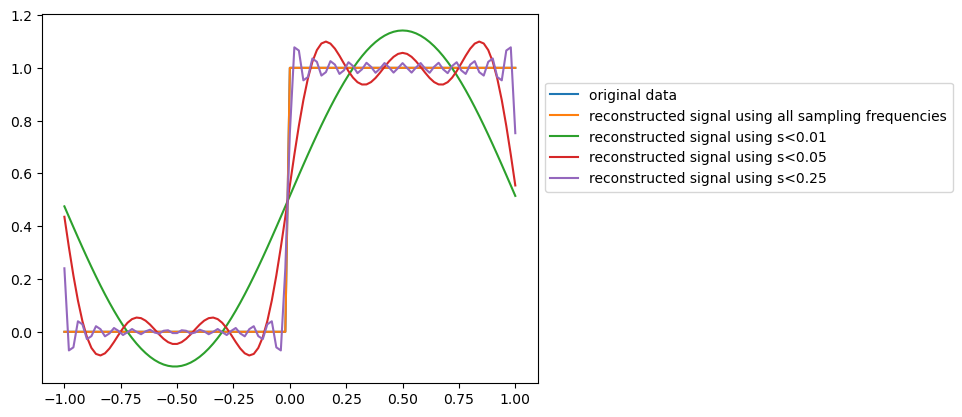

In [4]:
# lets start off with an example 
# lets take the fourier transform of a rectangle and reconstruct it (taking the ifft)
# to start use all the frequencies, and then we will start using only some frequencies

x=np.linspace(-1,1+1e-10,101)
r=np.zeros(len(x))
r[x>0]=1

plt.plot(x,r,label='original data')

R=fft.fft(r)
#combine back together using all the wave numbers
r2=fft.ifft(R)

s=fft.fftfreq(len(x))

plt.plot(x,r2,label='reconstructed signal using all sampling frequencies')

R3=np.copy(R)
R3[np.abs(s)>=0.01]=0

R4=np.copy(R)
R4[np.abs(s)>=0.05]=0

R5=np.copy(R)
R5[np.abs(s)>=0.25]=0

plt.plot(x,fft.ifft(R3),label='reconstructed signal using s<0.01')
plt.plot(x,fft.ifft(R4),label='reconstructed signal using s<0.05')
plt.plot(x,fft.ifft(R5),label='reconstructed signal using s<0.25')

plt.legend(loc=3,bbox_to_anchor=[1,0.5])

[1 4]
0
1
2
3


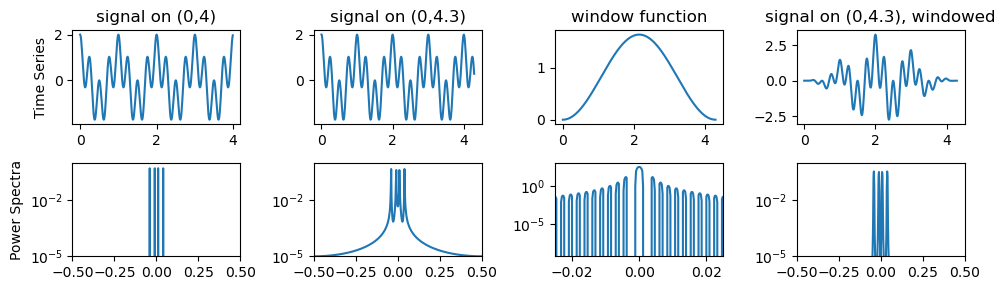

In [13]:
k=np.arange(1,7,3)
print(k)

titles=['signal on (0,4)',
        'signal on (0,4.3)',
        'window function',
        'signal on (0,4.3), windowed']

def cos_sum(k,t):
    return np.cos(2*np.pi*k[:,np.newaxis]*t[np.newaxis,:]).sum(axis=0)

dt=0.01
t0=np.arange(0,4,dt)
t1=np.arange(0,4.3,dt)
tl=[t0,t1,t1,t1]
cl = [cos_sum(k,t) for t in tl]
cl.insert(2,np.ones(len(t1)))

fig,axs=plt.subplots(2,4,figsize=(10,3))

for i,t,c in zip(range(0,4),tl,cl):
    print(i)
    if i in (2,3):
        c*=np.sqrt(8/3)*np.hanning(len(t))
    axs[0,i].plot(t,c)
    axs[0,i].set_title(titles[i])
#    axs[0,i].set_xlim([0,4])

    if not i==2:
        C = fft.fft(c)
        f = fft.fftfreq(len(t))
        axs[1,i].semilogy(fft.fftshift(f),fft.fftshift(C*np.conj(C))/len(C)*dt/2,'-')
        axs[1,i].set_xlim([-0.5,0.5])
        axs[1,i].set_ylim([1e-5,1e0])
    else:
        C = fft.fft(c,len(t)*10)
        f = fft.fftfreq(len(t)*10)
        axs[1,i].semilogy(fft.fftshift(f),fft.fftshift(C),'-')
        axs[1,i].set_xlim([-0.025,0.025])

    if i==0:
        axs[0,i].set_ylabel('Time Series')
        axs[1,i].set_ylabel('Power Spectra')

fig.tight_layout()



## Degrees of Freedom and Confidence Intervals 

- If we represent the uncertainty (standard deviation of our estimate) of $P_{xx}$ as $\sigma P_{xx}$, then $$\sigma P_{xx} = \frac{\sqrt{2 n}}{2} P_{xx}$$ where $n$ is the number of degrees of freedom in our solution
  
- Recall that $P_{xx}(s) = |X|^2(s)  = X_r^2(s) + X_i^2(s)$ where $X_r$ and $X_i$ are the real and imaginary parts of the Fourier transform of $X$. 
  - Thus there are only 2 degrees of freedom at each sampling frequency, and for a raw power specturm we have  $\sigma P_{xx} = P_{xx}$ 
  - In otherwords, the error in our estimate is as large as the estimate itself!
  
### The method of averaged periodograms 
- Obviously error as big as the estimate is not very good, somehow we need to increase the number of degrees of freedom in the solution. 
- One way to do this would be to get several estimates of the spectral solution, and then average them together to increase the degrees of freedom. 
- However nothing is ever free. By changing the length of the record that we are using we are going to change the number of sampling frequencies.
  - If we have $n$ overall samples our set of sampling frequencies would be $$ s_i = \frac{1}{n},...,\frac{i}{n},...\frac{n/2}{n} $$ so the smallest frequency we can resolve is $\frac{1}{n}$ and the largest frequency we can resolve is the Nyquist frequency $1/2$. 
  - If we split our data into $m$ samples, then the new sampling frequencies would be something like $$ s_i = \frac{1}{n/m},...,\frac{i}{n/m},...\frac{n/m/2}{n/m} $$, so the smallest frequency we can resolve is $\frac{1}{n/m}$ and the largest frequency we can resolve is still the Nyquist frequency $1/2$. The frequency resolution (the spacing between sampling frequencies) will be $\frac{1}{n/m}$ instead of $\frac{1}{n}$.

### The new confidence intervals 
  - As we add samples, the new estimate has a $\Chi^2$ distribution, so that the confidence intervals at the $\alpha$ level with $\nu$ degrees of freedom $$ \frac{\nu P}{\chi^2\left(\nu,\alpha/2\right)} \le P \le \frac{\nu P}{\chi^2\left(\nu,1-\alpha/2\right)}  $$
- for $m$ independent samples the total number of degrees of freedom will be $\nu=2m$.
- the the $\Chi^2$ distribution can be accessed in python similarly to the t-distribution using scipy.stats.chi2
- see extra material for more details on the $\Chi^2$ distribution and how the confidence intervals should change with $\nu$.

5000


/tmp/ipykernel_9878/1459428084.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for i in range(1,N): x[i]=x[i-1]*np.exp(-dt/tau)+np.sqrt(dt)*np.random.randn(1)
/tmp/ipykernel_9878/1459428084.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  Pxxsamples[i] = Xs*np.conj(Xs)/len(Xs)*dt/2
/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


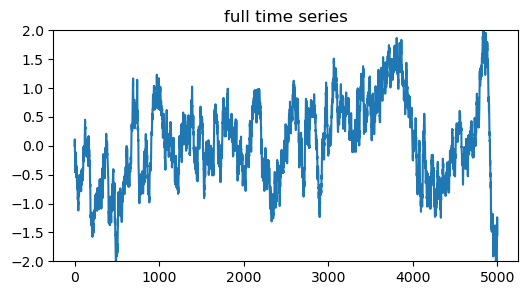

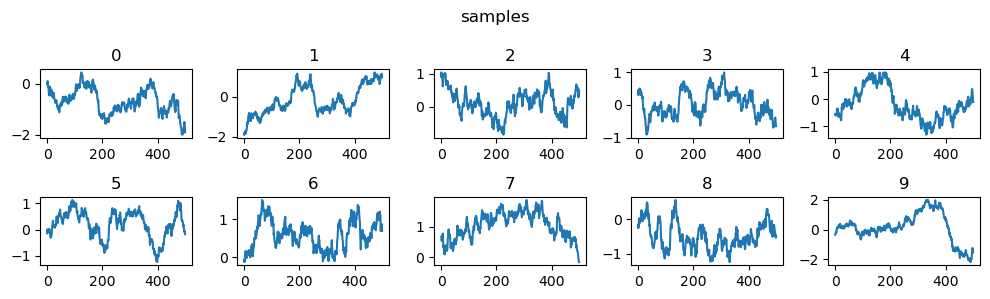

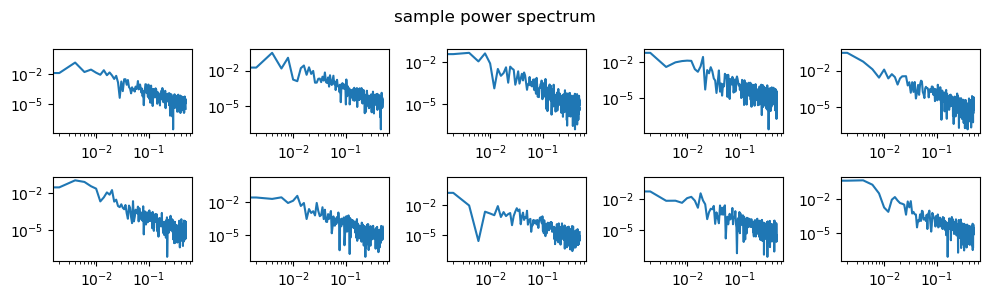

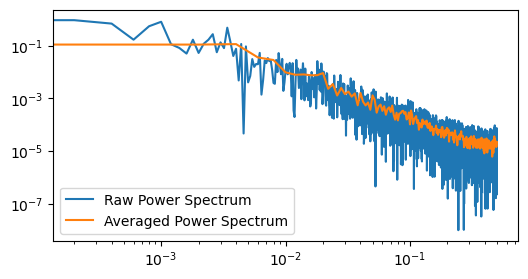

In [19]:
# lets generate some random data

dt=0.01; tau=1; N=int(50/dt); print(N)
x=np.zeros(N)
# Remember this?
for i in range(1,N): x[i]=x[i-1]*np.exp(-dt/tau)+np.sqrt(dt)*np.random.randn(1)
plt.figure(0,figsize=(6,3)); plt.plot(x); plt.ylim([-2,2]); plt.title('full time series')

Wlen = 500
Nwin = N//Wlen
Xsamples=np.zeros([Nwin,Wlen])
plt.figure(1,figsize=(10,3))
for i in range(0,Nwin): 
    Xsamples[i]=x[i*Wlen:(i+1)*Wlen]
    plt.subplot(2,5,i+1)
    plt.plot(Xsamples[i])
    plt.title(i)
plt.suptitle('samples')
plt.tight_layout()

Pxxsamples=np.zeros([Nwin,Wlen])
plt.figure(2,figsize=(10,3))
for i in range(0,Nwin): 
    plt.subplot(2,5,i+1)
    Xs = fft.fft(Xsamples[i])
    Pxxsamples[i] = Xs*np.conj(Xs)/len(Xs)*dt/2
    fs = fft.fftfreq(len(Xs))
    plt.loglog(fft.fftshift(fs),fft.fftshift(Pxxsamples[i]))
plt.suptitle('sample power spectrum')
plt.tight_layout()

plt.figure(3,figsize=(6,3))
plt.loglog(fft.fftshift(fft.fftfreq(len(x))),
           fft.fftshift(fft.fft(x)*np.conj(fft.fft(x)))/len(x)*dt/2,
           label='Raw Power Spectrum')
plt.loglog(fft.fftshift(fs),fft.fftshift(Pxxsamples.mean(axis=0)),
           label='Averaged Power Spectrum')
plt.legend()


### Putting it all together 
- So windowing our time series is useful to reduce noise, and so is taking lots of samples. 
- If we window our samples we will reduce how much we use the data at the edges of the windows 
- But if we take overlapping segments then we can use data from all the different parts of the time series
- If we choose to take windows that overlap by 50\%, then we get "Welch's Method"
- See the schematic below
  

<img src="../images/WelchMethod.png" width=50%, height=50%>


### Effective degrees of freedom 
- After windowing and/or doing overlap the effective degrees of freedom of the spectrum have been changed.
- Calculating exactly how much they have been changed is complicated (see extra material)
- However for some simple examples there are pre-tabluated results (assuming $m$ independent samples): 
- note that m can be different 

|Window/Overlap | Degrees of freedom|
| --- | --- |
| No window, 0 overlap | $2m$ |
| Hanning Window, 0 overlap |$2m$  |
| No Window, 50% overlap | $\frac{4}{3}$ m  |
| Hanning Window 50% overlap | $ \frac{36}{19}$ m  |



### Hypothesis testing with power spectra 
- When we calculated the mean, we were interested in questions such as "what is the mean of this data?" In this context, it makes a lot of sense to calculate the uncertainties of the estimator that you are using. 
- You can do this with spectra, but it's not usually that interesting, because usually what we want to do is to detect whether we have a significant signal. In order to do this, we need to choose a null hypothesis, and then calculate a spectrum to compare to. 
- A typical choice for this is to use a 1D OU process with a given autocorrelation length, usually chosen to be sufficiently long to be far away from any of the peak signals, or sometimes just a very long autocorrelation scale (lower than the lowest sampling frequency) so that the process looks like red noise. The noise strength of the 1D OU process also needs to be chosen in order to match the data, so that Parseval's theorem is satisfied. 
- Confidence intervals for the red noise spectrum can be created by using the 1d OU process spectrum and assuming that it has the same number of degrees of freedom as our estimate has
  - You can think about this as imagining what the estimate of the frequency would be if the sample actually was of a 1D OU process.
- Once the theoretical spectrum and confidence intervals have been calculated this can be plotted on the same plot as the actual data. Anywhere that the peak exceeds the confidence intervals this means that it the signal is statistically different than what you would expect from autocorrelated noise. 

# 3.3 - Cross Spectra

- This is the frequency version of cross correlation.
  
- imagine that we have two time series, $x$ and $y$, with fourier transformed versions $X=X_r+jX_i$ and $Y=Y_r+jY_i$. We could define a joint spectrum as $$P_{xy} = XY^*$$ or  $$P_{yx} = Y^*X$$
  
- In general $P_{xy}(s)$ is going to be a complex number, since unlike $P_{xx}$ there is no reason for $P_{xy}$ to be real. So we can write $$ P_{xy}(s) = C_{xy}(s) + Q_{xy}(s) $$ 
  - $C_{xy}=X_rY_r+X_iY_i$ is called the "co-spectra" 
  - $Q_{xy}=X_rY_i-X_iY_r$ is called the "quadrature spectra" 
  
- We can also write this in terms of an amplitude and frequency $$ P_{xy}(s) = |P_{xy}|(s)\exp\left(-j\theta_{xy}(s)\right)$$
  - $|P_{xy}|^2(s) = C_{xy}^2+Q_{xy}^2$ is the amplitude 
  - $\theta_{xy} = \tan^{-1}\left(Q_{xy}/C_{xy}\right)$ is the phase
  
- If we normalise $|P_{xy}|^2(s)$ we will get the coherence spectrum, $$G_{xy}(s) = \frac{|P_{xy}|^2(s)}{|P_{xx}|(s)|P_{yy}|(s)} $$
  - $G_{xy}$ will be between 0 and 1, and it represents how well the two signals "cohere" at that frequency. In particular if we set $x=y$, then $G_{xy}(s)=1$    
  - $G_{xy}$ is similar to a frequency dependent correlation coefficient

- $\theta_{xy}$ measures the phase differences between the two signals. 
  - if $\theta_{xy}=\pi/4$, this means that $x$ leads $y$ by 1 quarter of a cycle 
  - if $\theta_{xy}=-\pi/4$, this means that $y$ leads $xx$ by 1 quarter of a cycle

- So for 2 signals, we can get capture their cospectra by the coherence, which tells us something about how strong the two signals oscillate together at that frequency, and the phase difference, which tells us about and phase lead or lag between the two signals.

## Estimating coherence and phase spectra 

- At any given sampling frequency $s$, in order to estimate $G_{xy}(s)$ we need 4 peices of information: $X_r, X_i, Y_r, Y_i$. At each sampling frequency we only have 4 pieces of information. That means we have no degrees of freedom!
  - This means that our equations only have 1 solution, which we can find pretty easily: $$G_{xy}(s) = \frac{|P_{xy}|^2(s)}{|P_{xx}|(s)|P_{yy}|(s)} = \frac{\left(|X||Y|\right)^2}{|X|^2|Y|^2}=1$$

- In order to get a meaningful estimate of the coherence spectra we need to increase the number of degrees of freeom. This means that **we can only numerically estimate $G_{xy}(s)$ and $\theta_{xy}(s)$ with the method of averaged periodograms** (or similar method). If you try to use a raw power spectrum the results will just be $G_{xy}(s)=1$ and $\theta_{xy}(s)=0$ everywhere.

# 3.4 - Filtering
- Much of the filtering literature is concerned with designing circuits on measurement devices: e.g. there is some sensor which is making measurements every 5 mS, but I want to record a value every 2s. Doing this requires some fancy placement of resistors and capacitors, but for our purposes it doesn't really matter. This is the way that scipy.signal is written though, so if you see some weird terminology in the documentation that's where its coming from. 
- In the AOS literature often people will write something like "the data was smoothed using a 5 point running mean". This is a pet peave of mine, because it is a terrible choice as we will see below.

## - Finite Impulse Filtering 
- Imagine that we have a time series $x_k$ and we want a new time series $y_k$ that shows the low freqeuency variation and has less noise (later we'll show exactly what this means). We can do this by setting $$y_k = \sum_{i=-m}^{i=m} b_i x_{k+i} $$ where $b$ is a filter of length 2m+1: $$b=b_{-m},b_{-m+1},...b_0,...,b_{m-1},b_{m}$$ is a set of filter coefficients. 
    - this type of filter is known as a finite impluse filter because if we set $x_k=\delta_{ik}$ (an impulse) this will have an impact on a finite number of the $y_k$. 
    - In order to keep the magnitude of $y$ the same as $x$ we need $ \sum_{i} b_i = 1$.
    - If we set $b_i=\frac{1}{2m+1}$, then we will get the oft-mentioned "running point mean" filter, sometimes also called the "rectangular" or "box car" filter.
      - importantly we are using the same number of points before after each data point. If we use a different number of points before and after each data point we will create a "phase error", where the data before or after each data point will have a stronger influence on it. Phase errors are unavoidable in some real-time applications where you only have the data that has been captured before some time. However, if all the data has been collected there is no reason to have them.  
- What does our filter do? One way to understand this is with the convolution theorem: $$\begin{align*} y &=& x*h \\ \mathcal{F}(y) &=& \mathcal{F}(x)\mathcal{F}(h)\\ \implies P_{yy} &=& | \mathcal{F}(y) |^2 \\ &=& | \mathcal{F}(x) |^2 | \mathcal{F}(h) |^2 \\ &=& | P_{xx}|^2 \, |H(s) |^2 \\ \end{align*}$$
So the new data has a power spectrum which is the old power spectrum multipled by magnitude squared of the fourier transform of the filter coeffecients. The function $H(s)$ is often called the transfer function.
- The running mean has a transfer function: $$ H(s) = \sin(s)/s $$ also referred to as a sinc function. 
- In practice what we do is pick some value of $|H(s)|^2$ that we want, and then work backwards to figure out what the $h_i$ should be.
- A good example of this is the "Butterworth filter", which is defined so that $$|H(s)|^2 = \frac{1}{1+\left(\frac{s}{s_c}\right)^n} $$
    where $s_c$ is a critical sampling frequency, and $n$ is the order of the filter. When $s\ll s_c$ $|H(s)|^2\approx 1$, and when $s\ll s_c$ $|H(s)|^2\approx 0$. In the middle there will be a "
    "rolloff" of frequencies not quite filtered out correctly, but this will be sharper as $n\rightarrow \infty$. However as the frequency spectrum becomes closer and closer to a step function, the time space representation $h_i$ will need to become larger and larger and more data will have to be filtered into each point.
    - The Butterworth is probably the best "default" filter choice that you can make. 
    - scipy can be used to find $h_i$ using the scipy.signal.butter function, although the outputs are actually for a infinite impulse filter, as described below.  

## Infinite Impulse Response (IIR) Filtering
- Another way to do filtering would be if each of the filtered data was a linear combination of the filtered data itself, i.e.:
  $$\sum_{i=-m}^{i=m}a_i y_{k+i} = \sum_{i=-m}^{i=m}b_i x_{k+i} $$
- This is called infinite impulse response filtering, because if we add a spike to the data this will impact all filtered output since the filtered data are implicitly functions of each other.
- Calculating the response function for an IIR filter is a little bit complicated (see extra notes), but for our purposes its relatively easy to do numerically with python using the function signal.freqs (see below). Interpreting these functions is the same as for the FIR filter though.

## Types of filtering   
- Most of the time we are interested in creating a filter that removes high frequency data. This is called a "lowpass" filter.
- If you take your original time series and subtract the low pass filtered data the results will be only the remaining higher frequencies. This is called a high pass filter.
- If you choose a low pass filter at $s_0$ and a high pass filter at $s_1$ and apply them both to a dataset and then subtract the filtered versions from the original version you will have only the remaining frequencies in the range $s_0<s<s_1$. This is called a "bandpass" filter. 
- If you took a bandpass filtered data set and subtracted it from the oringal dataset you would have all the sampling frequencies *except* for those in the range $s_0<s<s_1$. This is called a "bandstop" filter.
- Its possible to create highpass, bandpass, and bandstop IIR filters directly by choosing the coeffecients correctly. This is hard to figure out by hand, but scipy.signal already includes functionality for it (see below). 


/home/rfajber/m3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


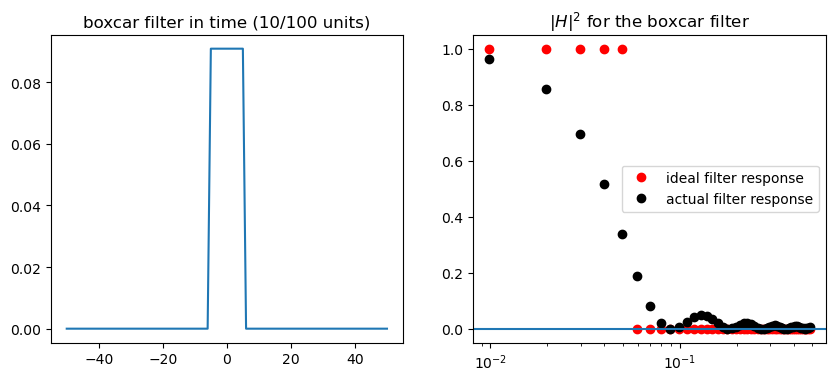

In [ ]:
x=np.linspace(-50,50,101)
#set up a 11 point running mean
r=np.zeros(len(x))
r[np.logical_and(x>=-5,x<=5)]=1
r/=np.sum(r)
R=fft.fft(r)
s=fft.fftfreq(len(x))

# what would the ideal filter response be?
# we're filtering with 11 points out of a time series of 101
# so the Nyquist frequency of our new dataset should be 0.5*11/101
# in an ideal filter below this frequency everything should be 1
# and above this everythign should be 0
sideal=0.5*11/101
Rideal=np.zeros(len(s))
Rideal[s<sideal]=1

plt.figure(0,figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(x,r)
plt.title('boxcar filter in time (10/100 units)')

plt.subplot(1,2,2)
plt.title('$|H|^2$ for the boxcar filter')
plt.semilogx(s[:len(x)//2],Rideal[:len(x)//2],'ro',
             label='ideal filter response')
plt.semilogx(s[:len(x)//2],np.conj(R[:len(x)//2])*R[:len(x)//2],'ko',
             label='actual filter response')
plt.axhline(0)
plt.legend()

Text(0.5, 1.0, 'Butterworth filter $|H(s)|^2$')

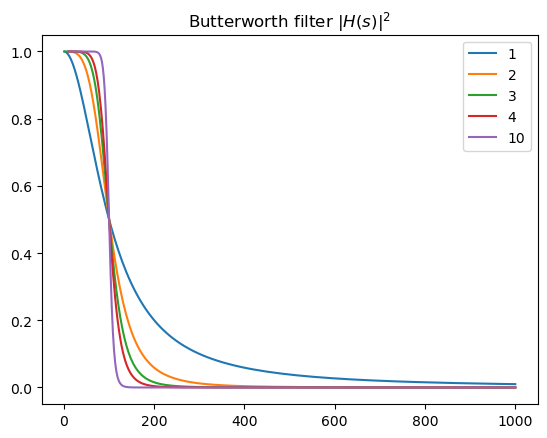

In [ ]:
for n in [1,2,3,4,10]:
    b, a = sig.butter(n, 100, 'low', analog=True)
    w, h = sig.freqs(b, a)
    plt.plot(w,
             h*np.conj(h),
             label=n)
plt.legend()

plt.title('Butterworth filter $|H(s)|^2$')

## Initial Conditions and Forwards-Backwards Filters

- One issue with filtering is what to do near the end points. If you have a filter that uses 5 points in front of and behind each data point, what do you do at the first data point? There are a coupled of options:
  1. ignore the first couple data points, reducing the length of the time series 
  2. try to make the derivatives near the edges "nice", this leads to something called Gustaffon's method.
  3. run the filter forwards and padd the data with zeros before the time series
  4. run the filter backwards and padd the data with zeros after the time sereis 

- Options 3 and 4 look strange, because as we discussed earlier this will lead to a phase error. However the phase error can be eliminated if we do **both** of them at the same time. This leads to something called the forwards-backwards filter. One the first pass going forward we will create a negative phase difference, but on the backward pass we will create a phase phase difference, which will cancel out the negative phase difference. 

### Implementing things in python
- scipy.signal has a variety of functions for computing filters:
  - signal.firwin will calculate the filter coeffecients for a FIR filter
  - signal.butter will calculate the b and a coeffecients needed for an IIR filter 
    - an optional argument into butter will let you convert between high pass, lowpass, and bandpass filters.
    - signal.freqs is a useful function for calculating the frequency response of an IIR filter.

- scipy.signal has 2 useful functions for filtering:
  - lfilter: this implements a single pass IIR filter
    - if you set the $a$ coeffecients to be 1 this will be the same as a FIR filter
  - sig.filtfilt: this implements a forwards-backwards IIR filter
    - the name filtfilt to describe forwards-backwards IIR filters is pretty common, matlab and julia also have filtfilt functions.
    - filtfilt also has an arguement called method which lets use change the method used 

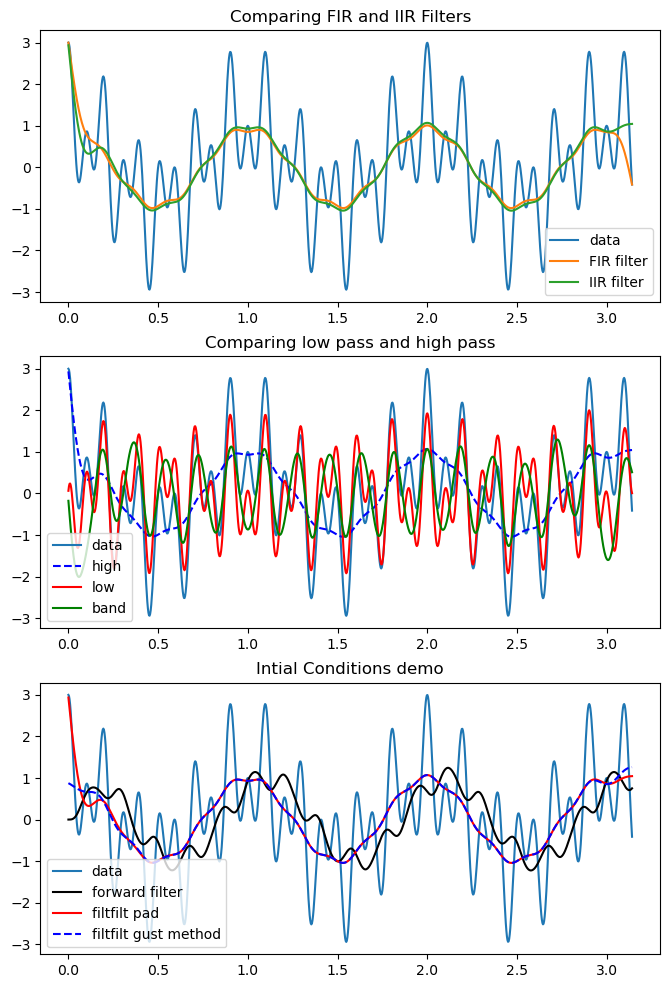

In [68]:
t=np.linspace(0,1,1001)*np.pi
c=cos_sum(np.linspace(1,10,3),t)

b, a = sig.butter(4, 0.025, 'low', analog=False)
bh, ah = sig.butter(4, 0.025, 'high', analog=False)
bp, ap = sig.butter(4, [0.01,0.05], 'band', analog=False)
bf = sig.firwin(numtaps=100,cutoff=0.025)

plt.figure(figsize=(8,12))

plt.subplot(3,1,1)

plt.plot(t,c,label='data')
plt.plot(t,sig.filtfilt(bf,[1.],c),label='FIR filter')
plt.plot(t,sig.filtfilt(b,a,c),label='IIR filter')
plt.title('Comparing FIR and IIR Filters')
plt.legend(loc=3)

plt.legend()

plt.subplot(3,1,2)
plt.plot(t,c,label='data')
plt.plot(t,sig.filtfilt(b,a,c),'b--',label='high')
plt.plot(t,sig.filtfilt(bh,ah,c),'r',label='low')
plt.plot(t,sig.filtfilt(bp,ap,c),'g',label='band')
plt.title('Comparing low pass and high pass')
plt.legend(loc=3)

plt.subplot(3,1,3)

b, a = sig.butter(4, 0.025, 'low', analog=False)

plt.plot(t,c,label='data')
plt.plot(t,sig.lfilter(b,a,c),'k',label='forward filter')
plt.plot(t,sig.filtfilt(b,a,c),'r',label='filtfilt pad')
plt.plot(t,sig.filtfilt(b,a,c,method='gust'),'b--',label='filtfilt gust method')
plt.title('Intial Conditions demo')
plt.legend(loc=3)

# 3.5 - Wavelets

- Fourier modes have a lot of problems with edge effects and non-periodic data. Windowing is one way to handle this, another way to handle this would be to use a localized version of a fourier mode, something like a "wave packet". This is the idea behind wavelett analysis - to avoid the problems of using fourier modes by using a wave packet instead of a wave. 
- If you think that a fourier transform is "convolving a time series with a wave", then a continous wavelett transform is "convolving a time series with a wavepacket".
- Tragically, the people who wrote scipy use an inconsitent notation with what I've used in this section up until now. To try and be consistent with both, I'm going to use $s_w$ to denote the scale parameter that is called $s$ in scipy.
- If you're interested in using wavelets for research I strongly reccomend reading the paper:
    Torrence, Christopher, and Gilbert P. Compo. "A practical guide to wavelet analysis." Bulletin of the American Meteorological society 79.1 (1998): 61-78.
- Note - wavelets are a much more complicated topic than what I am discussing here. We're going to focus on the continous Wavelet transform with the Morlet wavelet because it connects well with the rest of the course, but there are many other types of wavelets, both discrete and continuous. A notable example is that JPEG compression is built using discrete wavelets. 
  
## The Morlet Wavelet

- The "Morlet" wavelett is defined by $$ W(t,\omega_0,s_w) = \exp\left(j \, \omega_0 \, t \,s_w\right) \exp\left(-\frac{1}{2}\left(\frac{t}{s_w}\right)^2\right) \pi^{-\frac{1}{4}}\frac{1}{\sqrt{s_w}} $$
  - The first factor is a fourier mode, the second factor is a gaussian envelope, and the last factor is a normalization factor
  - There is an example of a Morlet Wavelett that you can play with after this section if you want to visualize what this looks like.
  - sometimes this gets called the Gabor wavelett, or the real part of the Morlet Wavlett gets called the Gabor wavelett. 
- There are two important parameters in the Morlet wavelett, $\omega_0$ and $s_w$. $\omega_0$ will control how many oscillations are contained inside the envelope, and $s_w$ will control the size of the envelope. 
  - If the data is sampled with time interval $dt$ these two parameters are related to the sampling frequency of an equivalent fourier mode by  $$s = \frac{\omega_0}{2\pi\,s_w \, dt} $$
  - Because of the windowing this Fourier mode would have an amplitude that is reduced by 0.76.
  - This is also contained in the example below


0.01909859317102744 50


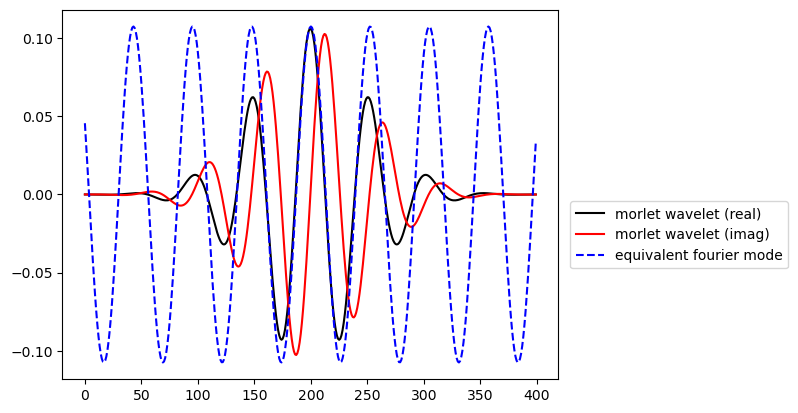

In [ ]:
N=400
fs=1
s=50
w=6
f=w/(2*s*np.pi)
print(f,s)
w=sig.morlet2(N,s,w=w)
plt.plot(np.real(w),'k',label='morlet wavelet (real)')
plt.plot(np.imag(w),'r-',label='morlet wavelet (imag)')
plt.plot(1/np.sqrt(s)*0.76*np.cos(2*np.pi*np.arange(-len(w)//2,len(w)//2)*f),'b--',label='equivalent fourier mode')

plt.legend(bbox_to_anchor=[1.01,0.5])

## The Continous Wavelet Transfrom

- For an input time series $x(t)$ the continuous wavelet transform is $$\mathrm{CWT}\left(t,\omega_0,s_w\right) = \int^{\infty}_{-\infty} W^*(t-u,\omega_0,s_w) x(u) du $$ where the $*$ indicates the complex conjugate.
- Like the fourier transform, this is a convolution. Unlike the fourier transform, the wavelet transform retains information about time. This is because the fourier transform uses waves which are non-zero over the entire domain, whereas the wavelet transform uses wave packets which are tapered to 0 outside of a small window. 
- Near a given time $t$ the $CWT$ will be large if $x(t)$ has a frequency that is close to $s = \frac{\omega_0}{2\pi\,s_w \, dt}$. By adjusting $s_w$ we can adjust which frequency range we are evaluating. 
- The parameter $\omega_0$ is essentially evaluating how many samples we are using in each wavelet to estimate the strength of oscillations in a given frequency band. For instance if we choose $\omega_0=6$, then there will be close to $6$ fluctuations inside each wave envelope that we can use to estimate the strength of the signal in that band (see the example above to get some ideas of how the wavelet changes when $\omega_0$ is changed).
- The key to using a continous wavelet transform is that we evaluate the transform holding $\omega_0$ fixed but changing $t$ and $s_w$.  
  - This means that if we plot $\mathrm{CWT}$ as a function of $t$ and $s_w$ we can make plots showing how much the strength of each scale (or equivalently frequency) is contributing to the total signal *at that particular time t*. 
- skip ahead to the example below if you want an example of what this looks like.
- To implement the wavelet tranform, its often easier to do things with fourier transforms and the convolution thereom, i.e. $$ \mathrm{CWT} = \mathcal{F}^{-1}\left(\mathcal{F}(W)\,\mathcal{F}(x)\right) $$

### Choosing a range of $s_w$

- In principle you can pick any range of $s_w$ that you want.
- In practice evaluating the CWT can be computationally time consuming, so you want to pick a limited range of scales. Often using power of 2s works well, e.g. $$ s_{w,j} = dt \, 2^{j} $$
- Another choice is to choose a set of frequencies of equivalent fourier modes that you would like to use, and then find the $s_w$ using $$ s_w = \frac{\omega_0}{2\pi\,s \, dt}$$ 
- Typically the smallest scale that you can evaluate should be related to the nyquist frequency, and the largest scale should be chosen so that the wavelett can still fit within length of the timeseries (see the next section).

### The cone of influence
 
- Although the wavelet will avoid edge effects in the middle of the domain, there is a problem when the wavelet nears the edge of the domain. 
- By convention, we ignore data that is within 2 e-folding lengths of the edge of the domain in order to avoid any edge effects. For the morlet wavlet, this means any point that is within $\Delta t = \sqrt{2}s_wdt$ of the edge should be ignored
  - for different choices of the scale parameter $s_w$ this means that we will have to ignore more or less data
  - this ends up constraining the largest scale parameter that we can use, e.g. for a series of length $t$ we need to ensure that for the largest scale $$ \sqrt{2} s_w dt < t/2  $$
- On most plots involving wavelets they will show some area around the edges that are either shaded or hatched out to show that the values in these regions are being ignored. 
  - Because the unshaded section looks like a cone if you plot $\mathrm{CWT}$ logarthmically in $s_w$ this is called the "cone of influence" 
  
### calculating wavelets in python
- the Morlet wavelt is complex, and the wavelet transform is complex, so the output will be complex.
- By default if you define an array using np.zeros this will be real. By default numpy will broadcast complex input into a real array by just dropping the imaginary part.
  - If $G^2 = G_r^2 +G_i^2$, then dropping the imaginary part removes approximately half of the signal.
- To avoid this, the output array needs to be set as a complex array 

/tmp/ipykernel_7300/288789440.py:59: RuntimeWarning: invalid value encountered in divide
  widths[0]*coix/coix,widths[0]-np.abs(coix/(dt*np.sqrt(2))),


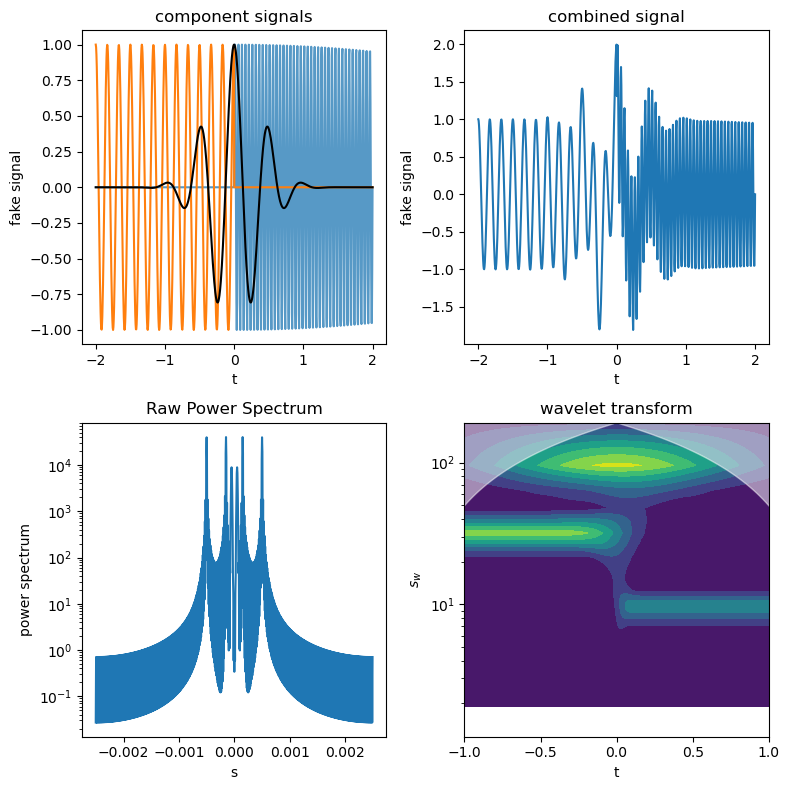

In [ ]:
t, dt = np.linspace(-2, 2, 800, retstep=True)

sig00  = np.cos(2 * np.pi * 6 * t)
sig00[len(t)//2:]=0
sig02 = np.sin(2 * np.pi * 20 * t) 
sig02[:len(t)//2]=0
sig01  = sig.gausspulse(t - 0, fc=2)
sig1  = sig00 + sig01 + sig02

fs = 1/dt
w = 6.

freq = np.linspace(1, fs/2, 100)
widths = w*fs / (2*freq*np.pi)
cwtm=np.zeros([len(t),len(widths)],dtype=np.complex128)

for i,width in enumerate(widths):
    N=len(sig1)
    wl=np.conj(sig.morlet2(N,width,w=w))
    W=fft.fft(
        np.conj(
            wl
        )
    )
    ctemp=fft.ifft(W*fft.fft(sig1))
    cwtm[:len(t)//2,i] = ctemp[len(t)//2:]
    cwtm[len(t)//2:,i] = ctemp[:len(t)//2]

plt.figure(0,figsize=(8,8))

plt.subplot(2,2,2)
plt.plot(t,sig1)
plt.title('combined signal')
plt.xlabel('t')
plt.ylabel('fake signal')

plt.subplot(2,2,1)
plt.plot(t,sig02,alpha=0.75)
plt.plot(t,sig00)
plt.plot(t,sig01,'k')
plt.title('component signals')
plt.xlabel('t')
plt.ylabel('fake signal')

plt.subplot(2,2,3)
freqs_fft=fft.fftfreq(len(sig1))
P = fft.fft(sig1)*np.conj(fft.fft(sig1))
plt.plot(dt*fft.fftshift(freqs_fft),fft.fftshift(P))
plt.yscale('log')
#plt.xlim([-0.5,0.5])
plt.title('Raw Power Spectrum')
plt.xlabel('s')
plt.ylabel('power spectrum')

plt.subplot(2,2,4)
plt.contourf(t, widths, np.abs(cwtm).T)
coix = np.linspace(-2,2,201)
plt.fill_between(coix,
                 widths[0]*coix/coix,widths[0]-np.abs(coix/(dt*np.sqrt(2))),
                    color='white',
                    alpha=0.5                                                      
                 )
plt.yscale('log')
plt.xlim([-1,1])
plt.title('wavelet transform')
plt.xlabel('t')
plt.ylabel('$s_w$')

plt.tight_layout()

# 3.X - Extra Material 

## The Chi Squared Distribution 

- The $\Chi^2$ distribution results from the sum of $n$ Gaussian variables with mean 0 and variance 1. 
- The exact shape of the distribution depends strongly on the degrees of freedom (number of variables being summed; see example below).
  - For a small number of degrees of freedom the pdf is similar to an exponential.
  - for a large number of degrees of freedom the pdf is similar to a Gaussian.
- For power spectra, the confidence intervals vary like  
  $$ \frac{\nu P}{\chi^2\left(\nu,\alpha/2\right)} \le P \le \frac{\nu P}{\chi^2\left(\nu,1-\alpha/2\right)}  $$

- So the relative normalized error, which is the difference between the central estimate and one confidence interval divided by $P$ is 
  $$ 1-\frac{\nu }{\chi^2\left(\nu,\alpha/2\right)}$$
  - This is plotted below. These plots are useful for estimating how many degrees of freedom you need to get your confidence intervals to be a given size.

Text(0.5, 1.0, 'PDF of $\\chi^2$ for different degrees of freedom')

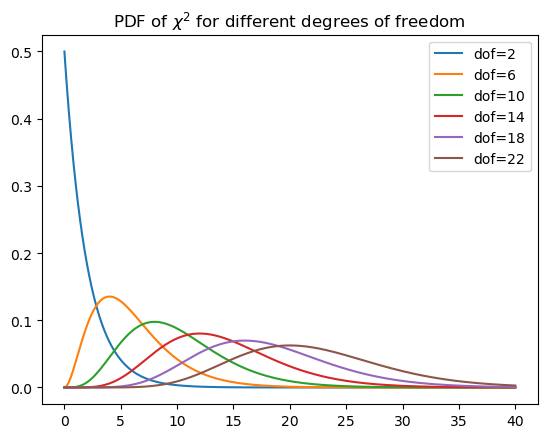

In [48]:
x=np.linspace(0,40,201)
dfl=np.arange(2,25,4)
for df in dfl:
    plt.plot(x,st.chi2.pdf(x,df=df),label=f'dof={df}')
plt.legend()

plt.title('PDF of $\\chi^2$ for different degrees of freedom')

Text(0.5, 1.0, 'Relative Normalized error: $1-\\frac{\\nu}{\\chi^2(\\nu,\\alpha/2 )}$')

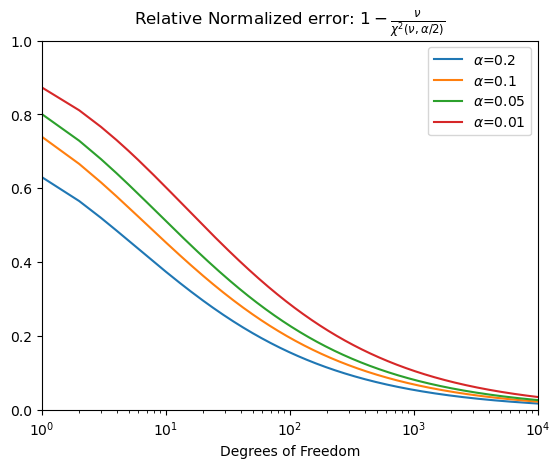

In [22]:
nu=np.arange(1,10000)
alphal=0.2,0.1,0.05,0.01
for alpha in alphal:
    X=st.chi2.ppf(1-alpha/2,
                  df=nu)
    plt.semilogx(nu,
                 1-nu/X,
                 label=f'$\\alpha$={alpha}')
plt.ylim([0,1])
plt.xlim([1,1e4])
plt.xlabel('Degrees of Freedom')
plt.legend()
plt.title('Relative Normalized error: $1-\\frac{\\nu}{\\chi^2(\\nu,\\alpha/2 )}$')

## Calculating degrees of freedom of window functions

This material comes from: Welch, Peter. "The use of fast Fourier transform for the estimation of power spectra: a method based on time averaging over short, modified periodograms." IEEE Transactions on audio and electroacoustics 15.2 (1967): 70-73.


- The error squared of the spectra of a Gaussian process is $$ \left(\sigma P_{xx}\right)^2 = \frac{P^2}{m}\left( 1 + 2 \sum_{j=1}^{n/m-1} \frac{n/m-j}{n/m} \rho(j)\right) $$ where $$\rho(j)= \left(\sum h(j)h(m-j)\right)^2 \left(\sum h^2(j) \right)^{-2} $$

- Comparing to the estimate without windowing or any overlap, this estimate would have $2m$ degrees of freedom. For a given window $\rho$ can be evaluated, and then the full expression in the first expression can be calculated, and the difference between this and the original expression gives the effective degrees of freedom.

## Transfer function for an IIR filter
- Remember that IIR filter is $$\sum_{i=-m}^{i=m}a_i y_{k+i} = \sum_{i=-m}^{i=m}b_i x_{k+i} $$
- The "z-transform" is defined as $$X(z) = \sum_{-\infty}^{\infty} xz^{-n} $$
  - The z-transform is similar to a fourier transform but it allows the amplitude of the oscillator function to change, which you can determine by noting that $$ z^{-n} = R\exp\left(j\omega n\right) $$
- The advantage of using a z-transform as opposed to a fourier transform for an IIR filter is that the implicit aspect may cause the size of the signal to change. Using the z-transform allows us to analyze the response function even when the amplitude of the signal is changing. 
- Similar to the Fourier transform the z-transform has its own convolution theorem, so that the equation for the IIR filter can be written $$A(z)Y(z) = B(z) X(z)$$ and so the transfer function can be written $$ H(z) =\frac{B(z)}{A(z)} $$ so that $$Y(z)=H(z)X(z)$$
- For practical purposes most of the time you can calculate these response functions numerically very quickly using scipy.signal.freqs. 

